In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [14]:
data = pd.DataFrame({
    "sweetness": [1,2,2,3,8,9,8,7],
    "crunchiness": [9,8,7,9,2,3,1,2],
    "label": ["Chips","Chips","Chips","Chips","Gummi","Gummi","Gummi","Gummi"]
})

<Axes: xlabel='sweetness', ylabel='crunchiness'>

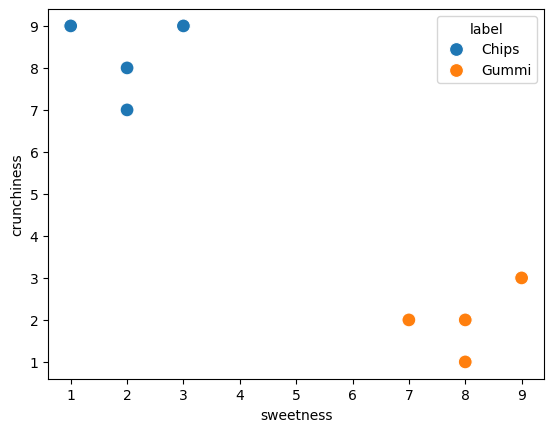

In [15]:
sns.scatterplot(data=data, x="sweetness", y="crunchiness", hue="label", s=100)

In [16]:
# --- Funktion zur Berechnung der Gini-Impurity ---
def gini_impurity(y):
    p = y.value_counts(normalize=True)
    return 1 - (p**2).sum()

In [17]:
# --- Gini des Parent-Knotens ---
parent_gini = gini_impurity(data["label"])

print(f"Gini des Parent-Knotens: {parent_gini:.3f}\n")


Gini des Parent-Knotens: 0.500



In [18]:
# --- Splitanalyse ---
thresholds = range(1, 10)
gini_values = []
delta_gini_values = []

print("t | Gini-Left | Gini-Right | Weighted Gini | ΔGini (Info-Gain)")
print("-"*65)

for t in thresholds:
    left = data[data["sweetness"] < t]["label"]
    right = data[data["sweetness"] >= t]["label"]
    
    gini_left = gini_impurity(left)
    gini_right = gini_impurity(right)
    weighted_gini = (
        len(left)/len(data)*gini_left
        + len(right)/len(data)*gini_right
    )
    delta_gini = parent_gini - weighted_gini
    
    gini_values.append(weighted_gini)
    delta_gini_values.append(delta_gini)
    
    print(f"{t:>2} | {gini_left:>10.3f} | {gini_right:>11.3f} | {weighted_gini:>14.3f} | {delta_gini:>16.3f}")

t | Gini-Left | Gini-Right | Weighted Gini | ΔGini (Info-Gain)
-----------------------------------------------------------------
 1 |      1.000 |       0.500 |          0.500 |            0.000
 2 |      0.000 |       0.490 |          0.429 |            0.071
 3 |      0.000 |       0.320 |          0.200 |            0.300
 4 |      0.000 |       0.000 |          0.000 |            0.500
 5 |      0.000 |       0.000 |          0.000 |            0.500
 6 |      0.000 |       0.000 |          0.000 |            0.500
 7 |      0.000 |       0.000 |          0.000 |            0.500
 8 |      0.320 |       0.000 |          0.200 |            0.300
 9 |      0.490 |       0.000 |          0.429 |            0.071


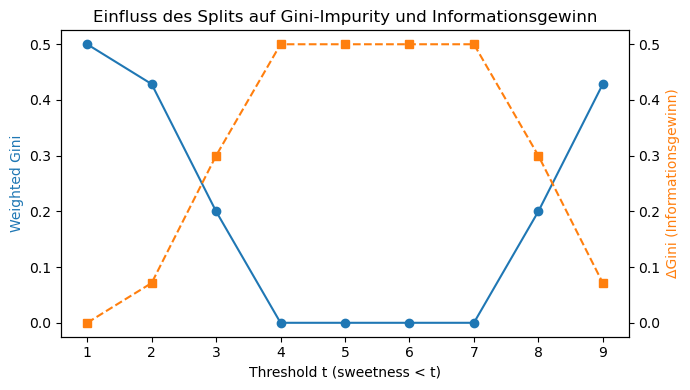

In [19]:
# --- Visualisierung: Gini & ΔGini ---
fig, ax1 = plt.subplots(figsize=(7,4))
ax1.plot(thresholds, gini_values, marker='o', label="Weighted Gini", color="tab:blue")
ax1.set_xlabel("Threshold t (sweetness < t)")
ax1.set_ylabel("Weighted Gini", color="tab:blue")

ax2 = ax1.twinx()
ax2.plot(thresholds, delta_gini_values, marker='s', linestyle='--', label="ΔGini (Info-Gain)", color="tab:orange")
ax2.set_ylabel("ΔGini (Informationsgewinn)", color="tab:orange")

plt.title("Einfluss des Splits auf Gini-Impurity und Informationsgewinn")
fig.tight_layout()
plt.show()

In [20]:
# --- Optimalen Split ausgeben ---
best_t = thresholds[pd.Series(gini_values).idxmin()]
print(f"\n Optimaler Split bei t = {best_t} "
      f"(min Gini = {min(gini_values):.3f}, max ΔGini = {max(delta_gini_values):.3f})")


 Optimaler Split bei t = 4 (min Gini = 0.000, max ΔGini = 0.500)


In [21]:
# Für mehrere Features

In [22]:
def gini_impurity(y: pd.Series) -> float:
    y = y.dropna()
    if len(y) == 0:
        return 0.0
    p = y.value_counts(normalize=True)
    return 1 - (p**2).sum()

In [23]:
def analyze_numeric_feature(df: pd.DataFrame, feature: str, target: str, *, max_unique: int = 200):
    """
    Prüft alle Midpoint-Schwellen des numerischen Features und gibt eine Tabelle
    mit Gini_left, Gini_right, weighted_gini und ΔGini zurück.
    Zusätzlich wird der beste Split (min weighted_gini / max ΔGini) angezeigt.

    Returns
    -------
    results_df : pd.DataFrame (sortiert nach weighted_gini aufsteigend)
    best_row   : pd.Series (beste Zeile)
    parent_gini: float
    """
    if feature not in df.columns or target not in df.columns:
        raise KeyError("Feature oder Target nicht in DataFrame.")

    x = df[feature]
    y = df[target]
    if not pd.api.types.is_numeric_dtype(x):
        raise TypeError(f"Feature '{feature}' ist nicht numerisch.")

    # Parent-Gini
    parent_gini = gini_impurity(y)

    # Midpoints zwischen sortierten Unique-Werten
    vals = np.sort(x.dropna().unique())
    if len(vals) <= 1:
        raise ValueError(f"Feature '{feature}' hat nicht genug unterschiedliche Werte.")
    if len(vals) > max_unique:
        idx = np.linspace(0, len(vals)-1, max_unique).round().astype(int)
        vals = vals[idx]
    thresholds = (vals[:-1] + vals[1:]) / 2.0

    rows = []
    n = len(df)
    for t in thresholds:
        left_mask = x < t
        right_mask = ~left_mask
        yL, yR = y[left_mask], y[right_mask]
        if len(yL) == 0 or len(yR) == 0:
            continue
        gL, gR = gini_impurity(yL), gini_impurity(yR)
        weighted_g = (len(yL)/n)*gL + (len(yR)/n)*gR
        dG = parent_gini - weighted_g
        rows.append({
            "feature": feature,
            "threshold": float(t),
            "n_left": int(len(yL)),
            "n_right": int(len(yR)),
            "gini_left": gL,
            "gini_right": gR,
            "weighted_gini": weighted_g,
            "delta_gini": dG
        })

    if not rows:
        raise ValueError("Keine gültigen Splits gefunden (evtl. NaNs/konstante Werte).")

    results_df = pd.DataFrame(rows).sort_values(["weighted_gini", "delta_gini"], ascending=[True, False]).reset_index(drop=True)

    # Schöne Konsolen-Ausgabe
    print(f"\nFeature: {feature} | Gini(Parent) = {parent_gini:.3f}")
    print("t (threshold) | nL | nR | G_left | G_right | Weighted_G | ΔGini")
    print("-"*70)
    for _, r in results_df.head(20).iterrows():  # nicht endlos lang werden
        print(f"{r['threshold']:>12.4f} | {r['n_left']:>2} | {r['n_right']:>2} | "
              f"{r['gini_left']:>6.3f} | {r['gini_right']:>7.3f} | "
              f"{r['weighted_gini']:>10.3f} | {r['delta_gini']:>6.3f}")

    best_row = results_df.iloc[0]
    print(f"\n➡Bester Split für '{feature}': {feature} < {best_row['threshold']:.4f}  "
          f"(min weighted_gini = {best_row['weighted_gini']:.3f}, max ΔGini = {best_row['delta_gini']:.3f})")

    return results_df, best_row, parent_gini


In [25]:
# sweetness analysieren
tab_sweet, best_sweet, parent_g = analyze_numeric_feature(data, "sweetness", "label")


Feature: sweetness | Gini(Parent) = 0.500
t (threshold) | nL | nR | G_left | G_right | Weighted_G | ΔGini
----------------------------------------------------------------------
      5.0000 |  4 |  4 |  0.000 |   0.000 |      0.000 |  0.500
      2.5000 |  3 |  5 |  0.000 |   0.320 |      0.200 |  0.300
      7.5000 |  5 |  3 |  0.320 |   0.000 |      0.200 |  0.300
      1.5000 |  1 |  7 |  0.000 |   0.490 |      0.429 |  0.071
      8.5000 |  7 |  1 |  0.490 |   0.000 |      0.429 |  0.071

➡Bester Split für 'sweetness': sweetness < 5.0000  (min weighted_gini = 0.000, max ΔGini = 0.500)


In [26]:
# crunchiness analysieren
tab_crunch, best_crunch, _ = analyze_numeric_feature(data, "crunchiness", "label")


Feature: crunchiness | Gini(Parent) = 0.500
t (threshold) | nL | nR | G_left | G_right | Weighted_G | ΔGini
----------------------------------------------------------------------
      5.0000 |  4 |  4 |  0.000 |   0.000 |      0.000 |  0.500
      2.5000 |  3 |  5 |  0.000 |   0.320 |      0.200 |  0.300
      7.5000 |  5 |  3 |  0.320 |   0.000 |      0.200 |  0.300
      8.5000 |  6 |  2 |  0.444 |   0.000 |      0.333 |  0.167
      1.5000 |  1 |  7 |  0.000 |   0.490 |      0.429 |  0.071

➡Bester Split für 'crunchiness': crunchiness < 5.0000  (min weighted_gini = 0.000, max ΔGini = 0.500)


In [27]:
def plot_split(data, feature, threshold):
    plt.figure(figsize=(5,5))
    sns.scatterplot(data=data, x="sweetness", y="crunchiness", hue="label", s=100)
    if feature == "sweetness":
        plt.axvline(threshold, color="black", linestyle="--")
    else:
        plt.axhline(threshold, color="black", linestyle="--")

In [28]:
X = data[["sweetness","crunchiness"]]
y = data["label"]
clf = DecisionTreeClassifier(max_depth=2, criterion="gini", random_state=0)
clf.fit(X, y)

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


[Text(0.5, 0.75, 'crunchiness <= 5.0\ngini = 0.5\nsamples = 8\nvalue = [4, 4]\nclass = Chips'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 4\nvalue = [0, 4]\nclass = Gummi'),
 Text(0.375, 0.5, 'True  '),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]\nclass = Chips'),
 Text(0.625, 0.5, '  False')]

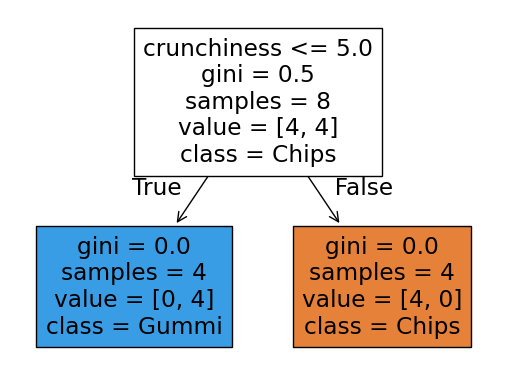

In [29]:
plot_tree(clf, feature_names=["sweetness","crunchiness"], class_names=clf.classes_, filled=True)

In [30]:
np.random.seed(0)
n = 100
data = pd.DataFrame({
    "sweetness": np.random.uniform(0,10,n),
    "crunchiness": np.random.uniform(0,10,n),
})
data["label"] = np.where(
    data["sweetness"] + np.random.normal(0,1,n) > data["crunchiness"], "Gummi", "Chips"
)

In [31]:
def gini_impurity(y: pd.Series) -> float:
    y = y.dropna()
    if len(y) == 0:
        return 0.0
    p = y.value_counts(normalize=True)
    return 1 - (p**2).sum()

In [32]:
def numeric_thresholds(s: pd.Series, max_unique: int = 100):
    """Midpoints zwischen sortierten Unique-Werten als Kandidaten.
       max_unique limitiert sehr feingranulare Features."""
    vals = np.sort(s.dropna().unique())
    if len(vals) <= 1:
        return []
    if len(vals) > max_unique:
        # gleichmäßig sampeln, damit es flott bleibt
        idx = np.linspace(0, len(vals)-1, max_unique).round().astype(int)
        vals = vals[idx]
    mids = (vals[:-1] + vals[1:]) / 2.0
    return mids

In [33]:
def evaluate_numeric_split(X_col: pd.Series, y: pd.Series, thresholds):
    parent_g = gini_impurity(y)
    rows = []
    for t in thresholds:
        left_mask = X_col < t
        right_mask = ~left_mask
        yL, yR = y[left_mask], y[right_mask]
        if len(yL) == 0 or len(yR) == 0:
            continue
        gL, gR = gini_impurity(yL), gini_impurity(yR)
        w = len(yL)/len(y)*gL + len(yR)/len(y)*gR
        d = parent_g - w
        rows.append({"threshold": float(t), "gini_left": gL, "gini_right": gR,
                     "weighted_gini": w, "delta_gini": d,
                     "n_left": len(yL), "n_right": len(yR)})
    if not rows:
        return None, None, None
    df = pd.DataFrame(rows).sort_values("weighted_gini")
    best = df.iloc[0]
    return df, "numeric", best

In [34]:
def evaluate_categorical_split(X_col: pd.Series, y: pd.Series, max_categories: int = 20):
    """One-vs-Rest für jede Kategorie (didaktisch & effizient)."""
    parent_g = gini_impurity(y)
    cats = X_col.dropna().astype("category").cat.categories.tolist()
    if len(cats) == 0:
        return None, None, None
    if len(cats) > max_categories:
        # viele Kategorien -> nimm häufigste top-k
        top = X_col.value_counts().head(max_categories).index.tolist()
        cats = [c for c in cats if c in top]
    rows = []
    for c in cats:
        left_mask = (X_col == c)  # {c} vs Rest
        right_mask = ~left_mask
        yL, yR = y[left_mask], y[right_mask]
        if len(yL) == 0 or len(yR) == 0:
            continue
        gL, gR = gini_impurity(yL), gini_impurity(yR)
        w = len(yL)/len(y)*gL + len(yR)/len(y)*gR
        d = parent_g - w
        rows.append({"category": c, "gini_left": gL, "gini_right": gR,
                     "weighted_gini": w, "delta_gini": d,
                     "n_left": len(yL), "n_right": len(yR)})
    if not rows:
        return None, None, None
    df = pd.DataFrame(rows).sort_values("weighted_gini")
    best = df.iloc[0]
    return df, "categorical", best

In [35]:
def find_best_split(X: pd.DataFrame, y: pd.Series, verbose=True):
    """Suche über alle Spalten: bester Split (numeric thresholds / categorical one-vs-rest)."""
    parent_g = gini_impurity(y)
    if verbose:
        print(f"Gini (Parent): {parent_g:.4f}\n")

    candidates = []   # sammelt nur die Bestwerte je Feature
    details = {}      # speichert komplette Tabellen pro Feature

    for col in X.columns:
        s = X[col]
        if pd.api.types.is_numeric_dtype(s):
            ths = numeric_thresholds(s)
            df, ftype, best = evaluate_numeric_split(s, y, ths)
        else:
            df, ftype, best = evaluate_categorical_split(s, y)

        if df is None:
            continue
        details[col] = (ftype, df)
        row = {
            "feature": col,
            "type": ftype,
            "weighted_gini": best["weighted_gini"],
            "delta_gini": best["delta_gini"],
            "n_left": int(best["n_left"]),
            "n_right": int(best["n_right"])
        }
        if ftype == "numeric":
            row["rule"] = f"{col} < {best['threshold']:.4f}"
        else:
            row["rule"] = f"{col} == '{best['category']}'"
        candidates.append(row)

    if not candidates:
        if verbose:
            print("Kein gültiger Split gefunden (evtl. nur 1 Klasse oder zu viele NaNs).")
        return None, None, None

    cand_df = pd.DataFrame(candidates).sort_values(["weighted_gini", "delta_gini"], ascending=[True, False])
    if verbose:
        print("Beste Kandidaten pro Feature (sortiert):")
        print(cand_df[["feature","type","rule","weighted_gini","delta_gini","n_left","n_right"]].to_string(index=False))
        print()

    # global bester Split
    best_row = cand_df.iloc[0]
    best_feature = best_row["feature"]
    best_type, df_full = details[best_feature]

    if verbose:
        print(f"➡️ Bester Split: {best_row['rule']}")
        print(f"   weighted Gini = {best_row['weighted_gini']:.4f}, ΔGini = {best_row['delta_gini']:.4f}")
    return best_row, details, cand_df

In [36]:
snacks = pd.DataFrame({
    "sweetness": [1,2,2,3,8,9,8,7],
    "crunchiness": [9,8,7,9,2,3,1,2],
    "label": ["Chips","Chips","Chips","Chips","Gummi","Gummi","Gummi","Gummi"]
})

X_snack = snacks[["sweetness","crunchiness"]]
y_snack = snacks["label"]

best, details, ranking = find_best_split(X_snack, y_snack, verbose=True)

Gini (Parent): 0.5000

Beste Kandidaten pro Feature (sortiert):
    feature    type                 rule  weighted_gini  delta_gini  n_left  n_right
  sweetness numeric   sweetness < 5.0000            0.0         0.5       4        4
crunchiness numeric crunchiness < 5.0000            0.0         0.5       4        4

➡️ Bester Split: sweetness < 5.0000
   weighted Gini = 0.0000, ΔGini = 0.5000


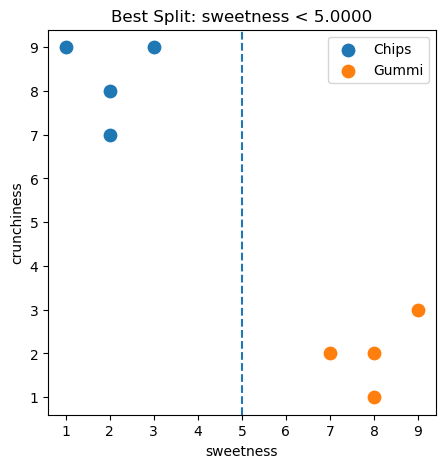

In [37]:
if best is not None and pd.api.types.is_numeric_dtype(X_snack[best["feature"]]) and X_snack.shape[1] == 2:
    feat = best["feature"]
    # Schwelle aus Detailtabelle ziehen
    ftype, df_full = details[feat]
    thr = df_full.iloc[0]["threshold"] if "threshold" in df_full.columns else None

    plt.figure(figsize=(5,5))
    # Punkte einfärben
    # (kein seaborn nötig)
    labels = y_snack.unique().tolist()
    for lbl in labels:
        m = (y_snack == lbl)
        plt.scatter(X_snack.loc[m, X_snack.columns[0]],
                    X_snack.loc[m, X_snack.columns[1]],
                    label=str(lbl), s=80)
    # Split-Linie zeichnen (vertikal oder horizontal)
    if feat == X_snack.columns[0] and thr is not None:
        plt.axvline(thr, linestyle="--")
    elif feat == X_snack.columns[1] and thr is not None:
        plt.axhline(thr, linestyle="--")
    plt.xlabel(X_snack.columns[0]); plt.ylabel(X_snack.columns[1])
    plt.title(f"Best Split: {best['rule']}")
    plt.legend()
    plt.show()